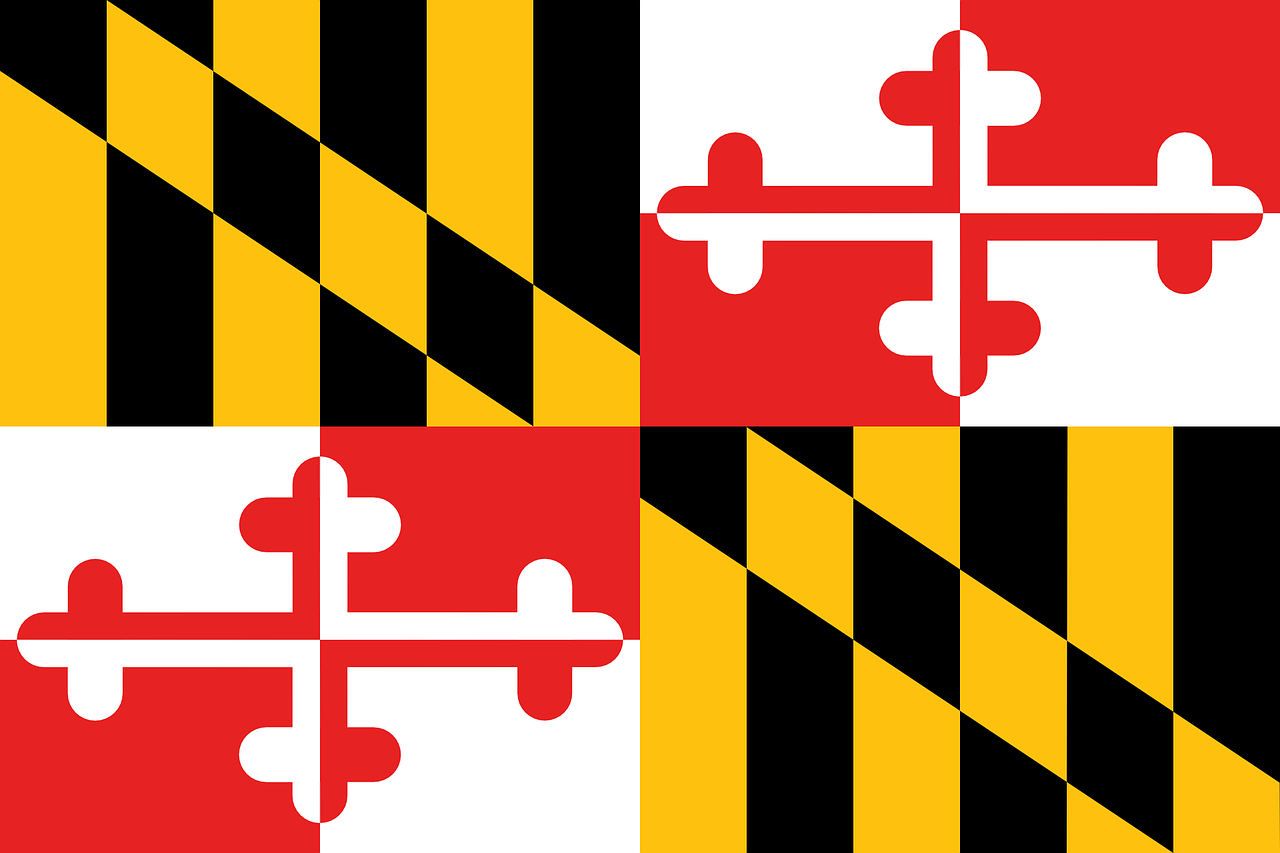

# COVID-19 County Breakdown -- Maryland

This project is meant to provide an accurate picture of the progression of COVID-19 cases in Maryland, US. I hope this information is found to be useful and informative! This is my second notebook so far, so please note that some of my approaches may be weaker than professional data scientists and feel free to leave comemnts on how to improve! 

**Latest Update Section:**
This section describes the latest updates to the document: Starting 1/05/2021

Updated 1/05/2021: Adding a number of new heatmap visualizations. Updated conclusions. Added images

Updated 1/12/2021: Fixed a number of mistakes in wording and conclusions. 

Updated 1/17/2021: Added clarification regarding the dataset, changed goals, fixed a mistake removing Washington county from the data. **Predictions will be done in a seperate notebook due to current resources used by this notebook**. This requires extra data and research, whereas this notebook serves as the introduction to the next.

Further updates: Further updates will include merely updating the dataset for the most updated picture of the spread. This notebook is purely the **visualization** of COVID-19 in Maryland. The predictions are being split into a second notebook to both segment the project into two parts, and improve the running speed of the notebook for editing. It will use the dataset discoverable [here](https://www.kaggle.com/binarydragon/median-household-income-maryland-2018) as well as the us-counties-covid-19 dataset already in use.

The predictions notebook will be discoverable soon at: *link* WIP

***Important Note about the data: ***

The us-counties-covid-19-dataset provided by the New York Times tracks *cumulative* case/death counts, not cases at a given moment.

# Table of Contents

1. Introduction
2. Data Manipulation/Code Setup
3. Visualizations 
4. Visualiations -- At a Glance 
5. Concluding Note

# 1. Introduction

To begin this project, we must first lay out our goals. This is not for a competition, and this is not following some set guideline(s) for data exploration. Instead, this notebook will set its own goals for exploration, with the hope of building a basis for later work to be built upon, or learned from. The COVID situation is continually evolving and, as such, this notebook will reflect that. Periodic updates may be applied to conclusions and predictions based on updates to the data from which said predictions are made. 

Therefore, to begin, let's lay out our goals, and a few important notes.
    
*Note 1:*
    
This *particular* notebook will be focused on the US State of Maryland, only, for the time being. This same level of analysis may be expanded to other states as well, time permitting. 

*Note 2:*

Due to the uncertainity of wide-spread testing in the United States, including the state of Maryland, these numbers may not be wholly accurate, or present the entire situation.

**Goal 1:** 

The data in the input category covers a date of entry, county, state, cases, and deaths. Namely, the "us-counties.csv" file. This data is enough to visualize the progression of COVID-19 in Maryland. As such, our first goal will be to map out the progression of COVID-19 in Maryland, county by county.

# 2. Data Manipulation/Code Setup

Below we'll be importing the libraries we need for our work, as well doing preliminary data manipulation. In short, this section will be broken down as follows...

1. Importing necessary libraries
2. Cutting our data down to only include Maryland counties
3. Checking for missing values, handling them. 

In [ ]:
# 2.1 Importing necessary libraries 

import pandas as pd # Data manipulation 
import numpy as np # lin. algebra
import seaborn as sns # Data visualization 
import copy # Python copying
# Set up matplot 
%matplotlib inline
import matplotlib.pyplot as plt # Data graph manipulation 

In [ ]:
# 2.2 Loading the data, cutting it down to only include Maryland. 

full_raw_data = pd.read_csv('../input/us-counties-covid-19-dataset/us-counties.csv') # Keep the entire dataset in a variable... in case it is needed.
                                                                         
maryland_raw_data = full_raw_data[full_raw_data.state == "Maryland"]

Alright now that we've taken care of that, we've got only one last step remaining... handling missing values. Let's head our data, and determine what we've got, and what it looks like.

In [ ]:
maryland_raw_data.head()

What we've done seems to have worked, and we've narrowed it down to only Maryland entries. But... as it is our job to deal with missing values, let's try and figure out how many missing values we have for each column.

In [ ]:
maryland_raw_data.info()

Interesting... considering that this dataset might be updated, we're going to save our total number of entries into a variable, and extract information from there. Though it's already clear that only fips contains missing values (note this may mean other fields will be invalid... if fips is missing, county is likely missing... as an example), as all the other columns are at the max number of entries, as of the most recent update. As such, for the purposes of the analyses in this notebook, **it will be assumed that the number of missing entries is equivalent to the number of missing fips values**. 

In [ ]:
# Total number of entries
total_entries = len(maryland_raw_data.index) # Keep track of the number of total entries. 
print("Total number of entries: %s" % total_entries)

# Total number of missing values from the fips category
total_fips_null = maryland_raw_data['fips'].isna().sum()
print("Total missing values: %s" % total_fips_null)

# Thus... total valid entries
print("Total valid entries: %s" % (total_entries - total_fips_null))

# Let's compile a list of all the rows with missing values, and take a look at it
missing_value_rows = maryland_raw_data[maryland_raw_data.isnull().any(axis=1)]

In [ ]:
missing_value_rows.head()

It's already quite clear then, that *not all values are null, or zero, if the **fips** value is null*. Some of the rows with missing fips values include case numbers as well, and death numbers, it's just that the counties are unknown. This data will be held, and kept, in case it's needed for further analysis at a later date... though, for now, it will be removed from the dataset over all (as this data will not aid in a county-by-county analysis). 

In [ ]:
maryland_raw_data = maryland_raw_data.dropna()
# Verify it worked... check that the total length is = (total_entries - total_fips_null)
print("(New length):%s =? (total - null):%s" % (len(maryland_raw_data), total_entries - total_fips_null))
if len(maryland_raw_data) != (total_entries - total_fips_null):
    # An error has occurred! Let's make it clear
    print("Procedural error! Mistake handling missing values, total entries - removed missing values != length of new raw_data array")
else:
    print("Correct! Missing values removed!")

Great! So we've handled missing variables! Now we've got just the pure data we want to analyze. Let's go ahead and make a copy of our data, and call it our official data *\"maryland_data\"*. 

Well, I spoke too soon. For ease of use in visualizations, this isn't a pure copy, as we'll be changing the index, or the value used to keep track of all the data in a list, into the dates. 

***As such, when a numerical index is needed, maryland_raw_data will be used, but maryland_data will be used for date indexes*** 

In [ ]:
maryland_data = maryland_raw_data.copy()
maryland_data.index = maryland_raw_data.date

# 3. Visualizations

Here we are! Finally time to take a look at the data we've got, and understand the spread of this disease, county by county. Let's head the data one more time, and take a look at the first few entries.

In [ ]:
maryland_data.head()

It would seem as if the very first entries for Maryland began after cases were officially detected. Let's verify this, and check if there were ever zero cases recorded. 

In [ ]:
zero_case_set = maryland_data[maryland_data.cases == 0]
print("Any rows with zero cases...? :: %s" % len(zero_case_set))
if len(zero_case_set) == 0:
    print("No rows with zero cases")
else:
    print("%s rows with zero cases" % len(zero_case_set))

That presents a bit of a problem, as it becomes a little more difficult, now, to track the spread of the virus across Maryland. If recording started so late, then it's likely it did in other counties as well, meaning tracking how the disease entered the state is much much more difficult. 

**Q: What did Maryland look like at the beginning of the pandemic?**

Please note the data is arranged chronologically.

In [ ]:
# Let's get the first date present in the data by checking the first row.
print(maryland_data.iloc[0]['date'])

first_date_string = maryland_data.iloc[0]['date']

*One more thing, the tpye of the values in the date column are strings, despite being dates. So, to make extraction easier (as they follow a common format... yyyy-mm-dd), we'll define a date class to use, personalized for our uses. To keep this notebook to the essentials, it's defined in a hidden code cell below, as well as the proof of the type.*

In [ ]:
# Define our date class...
class Date: 
    def __init__(self, date_string = "", year = None, month = None, day = None): # format for the date_string is "yyyy-mm-dd", dashes included!
        if date_string != "":
            self.year = int(date_string[:4])
            self.month = int(date_string[5:7])
            self.day = int(date_string[8:])
        else:
            self.year = year
            self.month = month
            self.day = day
            
        
    def __str__(self):
        return "%s-%s-%s" % (self.year, self.month, self.day)
    
    def __eq__(self, other):
        y_b = self.year == other.year
        m_b = self.month == other.month
        d_b = self.day == other.day
        
        if y_b == False: 
            if m_b == False: 
                if d_b == False:
                    return False
        else:
            return True
    
    def copy_add_year(self, amount):
        self.year += amount
        return Date("", self.year, self.month,self.day)
        
    def copy_add_month(self, amount):
        self.month += amount
        return Date("", self.year, self.month,self.day)
    
    def copy_add_day(self, amount):
        self.day += amount
        return Date("", self.year, self.month,self.day)
    
    def return_raw_string(self):
        if self.month < 10: 
            mangled_month = "0" + str(self.month)
        else:
            mangled_month = str(self.month)
            
        if self.day < 10: 
            mangled_day = "0" + str(self.day)
        else:
            mangled_day = str(self.day)
            
        return "%s-%s-%s" % (self.year, mangled_month, mangled_day)
            
        
print(type(maryland_data.iloc[0]['date'])) # Proof that the type is a string...
test_date = Date(maryland_data.iloc[0]['date'])
print(test_date) # Test that our date class is working

# assign our first date
first_date = Date(first_date_string)

In [ ]:
# Let's figure out what the first month of cases looked like in Maryland
# I'll provide a heatmap, as well as a bar graph of the first month of cases compared to the most recent data.


fig = plt.figure(figsize=(7, 15)) # make a figure
first_month_heat_ax = fig.add_subplot(2, 1, 1) # make a new axis. 
first_month_heat_ax.set_title("First Month")
bar_ax = fig.add_subplot(2, 1, 2) # make an axis for the barplot
final_date = Date(maryland_data.iloc[len(maryland_data) - 1]['date'])

# Heatmap creation technique: This covers one month in to the pandemic. 

one_month_in_date = first_date.copy_add_month(1) 
temp_data = maryland_data[maryland_data.date == one_month_in_date.return_raw_string()]
first_month_cases_data = {'Counties' : temp_data['county'], 'Cases' : temp_data['cases']}
temp_data = maryland_data[maryland_data.date == final_date.return_raw_string()]
last_day_cases_data = {'Counties' : temp_data['county'], 'Cases' : temp_data['cases']}
first_month_df = pd.DataFrame(first_month_cases_data)
last_day_df = pd.DataFrame(last_day_cases_data)

first_month_df.index = first_month_df.Counties
ax_3 = sns.barplot(x='Cases', y='Counties', data=last_day_df, label="Last Day Values", color='red', ax=bar_ax)
ax_2 = sns.barplot(x='Cases', y='Counties', data=first_month_df, label="First Month Values", color='blue', ax=bar_ax) 
                                                                              #This comes first to avoid the mentioned error below
plt.legend(title='Day')
#bar_ax.legend(labels=['Last Day Values','First Month Values'])
sns.despine(left=True, bottom=True)

del first_month_df['Counties'] # This needs to be deleted for the heatmap to work
print(first_month_df) # print our dataframe to see the exact numbers

ax_1 = sns.heatmap(data=first_month_df, ax=first_month_heat_ax)
plt.tight_layout()


Next question, do we have county data for each data? 
Ah... questions could be brought up, and answered, again and again when we're only working with text data. Let's map out each county's cases over time. Note, that there are not entries for all counties until the beginning of April, which is where the graphs will begin (as... again, there are not data for each county). 

In [ ]:
# We need to set the x-axis to be our dates and the y-axis to be our case numbers. To make things readable, we'll create a seperate line for each county. 
plt.figure(figsize=(32, 16))
county_names = maryland_data.county.unique() # Get all of the different county names, to plot each county
counter = 0 # Prepare a counter variable, in order to print our progress
for county in county_names: 
    counter += 1 # Update our counter. 1 will be the first value
    print("Processing: %s --> %s / %s" % (county, counter, len(county_names))) # Print progress
    temp_data = maryland_data[maryland_data.county == county] # get a subset of the data that ONLY INCLUDES THE CURRENT COUNTY
    graph = sns.lineplot(x='date', y='cases', data=temp_data, err_style="bars", label=county, legend=False) # plot the data for that county
    
plt.legend(loc='upper left') # place the legend, update it
xticks = graph.xaxis.get_major_ticks()
graph = graph.set_xticklabels(temp_data['date'], rotation=90) # make sure the date values are rotated
inital_i = 0
for i in range(len(xticks)):
    if inital_i == i or inital_i + 4 == i :
        xticks[i].set_visible(True)
        inital_i = i
    else:
        xticks[i].set_visible(False)

Let's plot the instaneous derivatives (the rate of change from day to day) of the case values, by county, for each day in the dataset. 

In [ ]:
#  Calculate instaneous derivatives for each county's cases on different dates. 

plt.figure(figsize=(32, 16)) # Prepare our plot... size it so it's readable


from numpy import diff # Import a function to help us calculate the derivative 
dx = 1.0 # The change on the x axis will be ONE DAY (the meaning of 1.0). Thus, dy/dx will be dy change for each DAY. 
counter = 0 # Prepare a counter variable, in order to print our progress
for county in county_names: 
    counter += 1 # Update our counter. 1 will be the first value
    print("Processing: %s --> %s / %s" % (county, counter, len(county_names))) # Print progress
    temp_data = maryland_data[maryland_data.county == county] # get a subset of the data that ONLY INCLUDES THE CURRENT COUNTY, this will be our y.
    y = temp_data['cases'].tolist() # Convert our cases to a list so the numpy.diff function will work
    dy = diff(y) / dx # REMEMBER, when we're calculating derivates simply by taking differences, the last value in the data will NOT BE INCLUDED
    #  This is handled below... in the graphing function. y = derivative of the cases, and the data includes all values but the last. 
    graph = sns.lineplot(x='date', y=dy, data=temp_data[:len(temp_data.index) - 1], err_style="bars", label=county, legend=False) # plot the data for that county

plt.legend(loc='upper left') # place the legend, update it
xticks = graph.xaxis.get_major_ticks()
graph = graph.set_xticklabels(temp_data['date'], rotation=90) # make sure the date values are rotated

inital_i = 0
for i in range(len(xticks)):
    if inital_i == i or inital_i + 4 == i :
        xticks[i].set_visible(True)
        inital_i = i
    else:
        xticks[i].set_visible(False)
    

plt.show()

Eek... this is a little messy. Seeing as the data varies so much, the derivatives are all over the place. What we're really hoping to see are negative derivatives, as then the case numbers would be decreasing.... but sadly we're not seeing enough of them to really be able to claim that it's not necessairly an error in the data. Let's see if we can try to *smooth* the derivatves so we can see a clear trend in the derivatives over time. 

There are a couple different methods we can apply to try and smooth our data. Here are the ones we'll apply, and the each one will be presented at the bottom for conculsions. **As such, the code to create each one, and the output, will be hidden, though can be viewed by clicking the code button below**. 

*We will be applying our smoothing for 7 days... so each week will have the same values depending on the smoothing technique.*

1. Average the values for all 7 days of the week. (Derivatives!) 
2. Pick the median value for all 7 days of the week. (Derivatives!)

In [ ]:
#### IMPORTANT !!! #####
derivative_smoothed_graphs = [] # List to hold each derivative smoothed graph. 
smoothed_d_graph = None # Variable to hold each respective graph
#  Method 1, average all 7 days' values.

plt.figure(figsize=(32, 16)) # Prepare our plot... size it so it's readable

### DECLARE VARIABLES ###

counter = 0 # reset our counter (for printing progress) to zero. 
averaged_derivatives_cases_dataframes = [] # create a list of dataframes for the derivative data, averaged, from each county.
averaged_derivatives_cases_dataframe = None # create a dataframe for ALL the derivative data, averaged, to be sorted by date (not county)

### ###

### PROCESS DERIVATIVES AND AVERAGES### 
for county in county_names: # For each county...
    counter += 1 # Update our counter. 1 will be the first value
    
    method_counter = 0 # Variable to help us keep track of our every 7 days averaging requirement 
    dy_averaged = [] # list of derivatives, averaged for 7 days.
    averaged_dates = [] # list of every 7 days. 
    continous_average = 0 # The average of the past 7 days (with the exception of the FIRST entry)
    average_denominator = 1 # The denominator for the average calculation. Set to 1 for the first entry
    
    print("Processing Derivative: %s --> %s / %s" % (county, counter, len(county_names))) # Print progress

    
    temp_data = maryland_data[maryland_data.county == county] # get a subset of the data that ONLY INCLUDES THE CURRENT COUNTY, this will be our y.
    y = temp_data['cases'].tolist() # Convert our cases to a list so the numpy.diff function will work
    dy = diff(y) / dx # REMEMBER, when we're calculating derivates simply by taking differences, the last value in the data will NOT BE INCLUDED
    
    for i in range(len(dy)): # for each day and each derivative
        if method_counter == 0: # if we're on the first value, or the start of a week...
            continous_average = sum(dy[:(i+1)]) / (i + 1) # calculate the average
            dy_averaged.append(continous_average) # append the current average 
            averaged_dates.append(temp_data.iloc[i]['date']) # append the current date so that the average is tracked
            method_counter += 1 # Next day!
        elif method_counter == 6: # Last day of the week, reset to zero so the first day of the NEXT week is recorded
            method_counter = 0 
        else: # Next day... next day... etc.
            method_counter += 1
            
    
    df = pd.DataFrame({'date' : averaged_dates, 'averaged derivatives of cases' : dy_averaged, 'county' : [
        county for c in range(len(averaged_dates))
    ]}) # Create a dataframe to hold all our dates, and all the averaged derivatives for EACH couonty
    df.index = df.date # set the index to date
    averaged_derivatives_cases_dataframes.append(df) # Append it to our list

### ###

### MERGE DATAFRAMES ###
    
print("Progress: Merging county derivative data")
averaged_derivatives_cases_dataframe = pd.concat(averaged_derivatives_cases_dataframes, axis=0) # conc. all the different counties' data. 
averaged_derivatives_cases_dataframe.index = averaged_derivatives_cases_dataframe['date'] # set the index (be sure the index is correct)

averaged_derivatives_cases_dataframe['date'] = pd.to_datetime(averaged_derivatives_cases_dataframe.date) # convert the date to datetime, so we can sort
averaged_derivatives_cases_dataframe.sort_index() # sort based on the datetime index

### ###

### GRAPH EVERYTHING! ###

counter = 0
for county in county_names:
    counter += 1 # Update our counter. 1 will be the first value
    
    print("Processing: %s --> %s / %s" % (county, counter, len(county_names))) # Print progress
    temp_data = averaged_derivatives_cases_dataframe[averaged_derivatives_cases_dataframe.county == county] # get a subset of the data that 
        #  ONLY INCLUDES THE CURRENT COUNTY
        
    smoothed_d_graph = sns.lineplot(x='date', y='averaged derivatives of cases', data=temp_data, err_style="bars", label=county, legend='full') # plot the data for that 
        #  county
### ###

derivative_smoothed_graphs.append(smoothed_d_graph) # Add the final version of the graph to the list for plotting later
plt.legend(loc='upper left') # place the legend, update it


In [ ]:
#  Method 2, pick the median value for all 7 days of the week.

from statistics import median
plt.figure(figsize=(32, 16)) # Prepare our plot... size it so it's readable

### DECLARE VARIABLES ###

counter = 0 # reset our counter (for printing progress) to zero. 
median_derivatives_cases_dataframes = [] # create a list of dataframes for the derivative data, median, from each county.
median_derivatives_cases_dataframe = None # create a dataframe for ALL the derivative data, median, to be sorted by date (not county)

### ###

### PROCESS DERIVATIVES AND MEDIAN ### 
for county in county_names: # For each county...
    counter += 1 # Update our counter. 1 will be the first value
    
    method_counter = 0 # Variable to help us keep track of our every 7 days median requirement 
    dy_median = [] # list of derivatives, median for 7 days.
    median_dates = [] # list of every 7 days. 
    continous_median = 0 # The median of the past 7 days (with the exception of the FIRST entry)
    
    print("Processing Derivative: %s --> %s / %s" % (county, counter, len(county_names))) # Print progress

    
    temp_data = maryland_data[maryland_data.county == county] # get a subset of the data that ONLY INCLUDES THE CURRENT COUNTY, this will be our y.
    y = temp_data['cases'].tolist() # Convert our cases to a list so the numpy.diff function will work
    dy = diff(y) / dx # REMEMBER, when we're calculating derivates simply by taking differences, the last value in the data will NOT BE INCLUDED
    
    for i in range(len(dy)): # for each day and each derivative
        if method_counter == 0: # if we're on the first value, or the start of a week...
            continous_median = median(dy[:(i+1)]) # calculate the median
            dy_median.append(continous_median) # append the current median 
            median_dates.append(temp_data.iloc[i]['date']) # append the current date so that the median is tracked
            method_counter += 1 # Next day!
        elif method_counter == 6: # Last day of the week, reset to zero so the first day of the NEXT week is recorded
            method_counter = 0 
        else: # Next day... next day... etc.
            method_counter += 1
            
    
    df = pd.DataFrame({'date' : median_dates, 'median derivatives of cases' : dy_median, 'county' : [
        county for c in range(len(median_dates))
    ]}) # Create a dataframe to hold all our dates, and all the median derivatives for EACH couonty
    df.index = df.date # set the index to date
    median_derivatives_cases_dataframes.append(df) # Append it to our list

### ###

### MERGE DATAFRAMES ###
    
print("Progress: Merging county derivative data")
median_derivatives_cases_dataframe = pd.concat(median_derivatives_cases_dataframes, axis=0) # conc. all the different counties' data. 
median_derivatives_cases_dataframe.index = median_derivatives_cases_dataframe['date'] # set the index (be sure the index is correct)

median_derivatives_cases_dataframe['date'] = pd.to_datetime(median_derivatives_cases_dataframe.date) # convert the date to datetime, so we can sort
median_derivatives_cases_dataframe.sort_index() # sort based on the datetime index

### ###

### GRAPH EVERYTHING! ###

counter = 0
for county in county_names:
    counter += 1 # Update our counter. 1 will be the first value
    
    print("Processing: %s --> %s / %s" % (county, counter, len(county_names))) # Print progress
    temp_data = median_derivatives_cases_dataframe[median_derivatives_cases_dataframe.county == county] # get a subset of the data that 
        #  ONLY INCLUDES THE CURRENT COUNTY
        
    smoothed_d_graph = sns.lineplot(x='date', y='median derivatives of cases', data=temp_data, err_style="bars", label=county, legend='full') # plot the data for that 
        #  county
### ###

derivative_smoothed_graphs.append(smoothed_d_graph) # Add the final version of the graph to the list in case it's needed
plt.legend(loc='upper left') # place the legend, update it


In [ ]:
fig_avg, ax_avg = plt.subplots()
fig_avg = plt.gcf()
fig_avg.set_size_inches(32, 16)
# Method 1
for county in county_names:    
    temp_data = median_derivatives_cases_dataframe[median_derivatives_cases_dataframe.county == county] # get a subset of the data that 
        #  ONLY INCLUDES THE CURRENT COUNTY
    temp_graph = sns.lineplot(x='date', y='median derivatives of cases', data=temp_data, err_style="bars", 
                              ax=ax_avg, 
                              label=county, legend='full').set_title("Averaged Instaneous Derivatives for Cases (Every 7 days)")# plot the data for that county
        
##
fig_med, ax_med = plt.subplots()
fig_med = plt.gcf()
fig_med.set_size_inches(32, 16)## 
# Method 2
for county in county_names:    
    temp_data = averaged_derivatives_cases_dataframe[averaged_derivatives_cases_dataframe.county == county] # get a subset of the data that 
        #  ONLY INCLUDES THE CURRENT COUNTY
    temp_graph = sns.lineplot(x='date', y='averaged derivatives of cases', data=temp_data, err_style="bars", 
                              ax=ax_med, 
                              label=county, legend='full').set_title("Median Instaneous Derivatives for Cases (Every 7 days)") # plot the data for that county
plt.legend(loc='upper left') # place the legend, update it


# 4. Visualizations -- At a Glance

The following section will present more visualizations by county so that the spread of this disease, county by county, can be better analyzed. In other words, this section is to *visualize* the change in COVID-19 cases quickly for easy reading. Heat Graphs, in my opinion, are more effective at giving an "at a glance" view of data.

**Heat Map:**

A heat map is presented below for a county by county analysis of cases, as well as deaths, for the most recent day in the dataset. 

In [ ]:
fig = plt.figure(figsize=(15, 15))
cases_ax = fig.add_subplot(1, 2, 1)
deaths_ax = fig.add_subplot(1, 2, 2)

final_date = maryland_data.iloc[len(maryland_data) - 1]['date']
print("Final date in the dataset is: %s" % final_date)

temp_data = maryland_data[maryland_data.date == final_date]
cases_data = {'Counties' : temp_data['county'], 'Cases' : temp_data['cases']}
deaths_data = {'Counties' : temp_data['county'], 'Deaths' : temp_data['deaths']}

cases_df = pd.DataFrame(cases_data)
cases_df.index = cases_df.Counties
del cases_df['Counties']
deaths_df = pd.DataFrame(deaths_data)
deaths_df.index = deaths_df.Counties
del deaths_df['Counties']

ax_1 = sns.heatmap(data=cases_df, ax=cases_ax)
ax_2 = sns.heatmap(data=deaths_df, ax=deaths_ax)
plt.tight_layout()

To explain the above graph, this presents a county-by-county presentation of the cases and deaths in Maryland on the latest day of data, with a color scale (lighter being greater numbers) to show current numbers.

Next, why don't we take a look at every single month for COVID-19 so far. We'll start with April 1st (as the data doesn't reliably have all counties until then), then May 1st, etc. etc. 

This is a more heartfelt way of tracking progression over time. 

In [ ]:
fig = plt.figure(figsize=(30, 30))
graphs = [] # Hold our heatmaps
months_axs = [] # Hold matplotlib axes
dframes = [] # Hold each temporary dataframe

# How many "1st's" are in the dataset? April 1st, May 1st, June 1st... etc.
num_months = 0
cleared_months = []
for entry in maryland_data.iloc:
    loop_date = Date(entry.date) # The date we're looping with 
    if loop_date.day == 1 and not (loop_date.year, loop_date.month, loop_date.day) in cleared_months: # If this is the first datapoint of that month
        cleared_months.append((loop_date.year, loop_date.month, loop_date.day)) # Add the date
        num_months += 1 # increment the number of months

# Create axes (cleaner to seperate this from the following loop)

cols = 0 # Number of cols for our graph to have
rows = 0 # Number of rows for our graph to have
remainder = num_months % 2 # Are we working with an even or odd number? remainder = 1 if odd, 0 if even
if remainder == 0:
    cols = num_months / 2
    rows = num_months / cols 
elif remainder == 1:
    cols = ((num_months - 1) / 2) + 1
    rows = num_months / cols
else:
    print("Error: remainder is not 1 or 0.")
    
for i in range(0, num_months): # For each month
    splot = fig.add_subplot(int(rows), int(cols), i + 1) # Add an axis
    splot.set_title("Month: %s" % (i + 1)) # Make unique titles for each plot to be clearly seperated
    months_axs.append(splot)

# For each number 1 date
for i in range(0, num_months):
    loop_date = Date("", cleared_months[i][0], cleared_months[i][1], cleared_months[i][2])
    print("Processing: %s" % loop_date)
    temp_data = maryland_data[maryland_data.date == loop_date.return_raw_string()] # Get all dates with the loop date
    temp_data = {'Counties' : temp_data['county'], 'Cases' : temp_data['cases']} # Make a new neater dataframe
    temp_df = pd.DataFrame(temp_data) # ... see above
    
    temp_df.index = temp_df.Counties # reset the index, date is not needed here.
    del temp_df['Counties'] # Get rid of the extra column. 
    dframes.append(temp_df)
    gr = sns.heatmap(data=dframes[i], ax=months_axs[i]) # make our graph, use a new axis and dataframe each time
    graphs.append(gr) # append it for safekeeping


plt.tight_layout() # Adjust the layout of our graph to be tight and neat. 

# Conclusion

While this is not a grand work, and while it only pertains to one state of 50 in the US, this notebook is meant to give viewers a little picture of the way the virus is proceeding in Maryland. 

Thank you for your time! I sincerly hope this project is helpful! 
As this is only my second notebook, any comments you may have would be a wonderful help below!